# Dubai housing analysis

## Author: Ankur Shanker

## Student ID: 21159916

### **Section 1:** Importing packages necessary for workbook exectuion.

Libraries necessary for workbook execution related to functionality responsible for geo-spatial data reading, plotting, and statistical analysis need to be imported in order for this workbook to function.

In [1]:
# Import packages required for analysis
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
import rfpimp

import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

In [3]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

In [4]:
# Import packages required for geospatial analysis
import geopandas as gpd
import pyproj
import geopy.distance
from shapely import geometry

In [5]:
# Import packages required for data visualisation
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sn
import matplotlib.colors as colors
sn.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [6]:
# Import packages required for numeric operations
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

### **Section 2:** Reading and formatting data

Data related to the housing industry of Dubai (courtsey of Knight Frank) is read in and interepreated below.

In [7]:
# Read in Dubai price data
transactional_data = pd.read_excel('Data/Dubai Data/TransactionalDatabase_Dubai.xlsx', skiprows=[0])

print(transactional_data.columns)
print(len(transactional_data))

Index(['Area', 'Neighbourhood', 'Building Name', 'Developer', 'Property Type',
       'Property Type [Exp.]', 'No. Rooms', 'No. Rooms [Exp.]', 'Size [sqf]',
       'Size Band', 'Land Area [sqf]', 'Price [AED]', 'Price Band', 'AED/sqf',
       'Transaction Type', 'Date', 'Year', 'Quarter', 'Month'],
      dtype='object')
523770


The dataset is filtered to only include transactional data related to apartment sales in Dubai.

In [8]:
transactional_data = transactional_data[transactional_data['Property Type [Exp.]'] == 'Apartment']

The maximum and minimum dates of reisdential apartment property sales is then determined (this is mentioned int eh dissertation) and spans an 18 year period.

In [9]:
print(transactional_data['Date'].max())
print(transactional_data['Date'].min())

2022-03-31 00:00:00
2004-05-05 00:00:00


Mean values for building size and resale price per square foot is then extracted for each residential buidling.

In [10]:
transactional_data = transactional_data.groupby(['Building Name'])[['Size [sqf]', 'AED/sqf']].mean().reset_index()
print(transactional_data.columns)
print(len(transactional_data))

Index(['Building Name', 'Size [sqf]', 'AED/sqf'], dtype='object')
3713


The location data for each residential property is then extracted.

In [11]:
location_data = pd.read_csv('Data/Dubai Data/Property_Residential.csv')
print(location_data.columns)
print(len(location_data))

Index(['Property', 'Status', 'No of Units', 'X', 'Y'], dtype='object')
3836


The dataset containing property transactional data (grouped and averaged by building name) and the locations of buildings in Dubai is then merged.

In [12]:
merged_df = location_data.merge(transactional_data, how='left', left_on='Property', right_on='Building Name')
merged_df = merged_df.dropna()
merged_df.columns

Index(['Property', 'Status', 'No of Units', 'X', 'Y', 'Building Name',
       'Size [sqf]', 'AED/sqf'],
      dtype='object')

In [13]:
merged_df = gpd.GeoDataFrame(merged_df, geometry=gpd.points_from_xy(merged_df['X'], merged_df['Y']))
merged_df = merged_df[['No of Units', 'Building Name', 'Size [sqf]', 'AED/sqf', 'geometry']]
merged_df.columns

Index(['No of Units', 'Building Name', 'Size [sqf]', 'AED/sqf', 'geometry'], dtype='object')

Following this the geolocation of malls in Dubai is read in and the data is transformed to the correct local EPSG code for Dubai.

In [14]:
dubai_mall_polygons = gpd.read_file('Data/Dubai Data/DubaiMalls/Malls_PlacesOfInterest.shp')
dubai_malls = pd.DataFrame()
dubai_malls['x'] = dubai_mall_polygons.centroid.x
dubai_malls['y'] = dubai_mall_polygons.centroid.y


dubai_mall_polygons = dubai_mall_polygons.to_crs({'init': 'epsg:3997'})
dubai_mall_polygons['area'] = dubai_mall_polygons['geometry'].area

dubai_malls['name'] = dubai_mall_polygons['name']
dubai_malls['area'] = dubai_mall_polygons['area']

dubai_malls = gpd.GeoDataFrame(dubai_malls,
                             geometry=gpd.points_from_xy(dubai_malls.x, dubai_malls.y))

dubai_malls = dubai_malls[['name', 'geometry', 'area']]

C:\Users\ankur\AppData\Local\Temp\ipykernel_22016\1865729211.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dubai_malls['x'] = dubai_mall_polygons.centroid.x
C:\Users\ankur\AppData\Local\Temp\ipykernel_22016\1865729211.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dubai_malls['y'] = dubai_mall_polygons.centroid.y
c:\Users\ankur\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepa

Malls are classified into three sizes (as discussed in the dissertation).

In [15]:
dubai_malls['LargeMall'] = dubai_malls['area'] > 50000
dubai_malls['MediumMall'] = (dubai_malls['area'] < 50000) & (dubai_malls['area'] > 20000)
dubai_malls['SmallMall'] = dubai_malls['area'] < 20000
print(dubai_malls.columns)
dubai_malls[['name', 'LargeMall', 'MediumMall', 'SmallMall']] # I am not permitted to show the actual areas as this is confidential information

Index(['name', 'geometry', 'area', 'LargeMall', 'MediumMall', 'SmallMall'], dtype='object')


,name,LargeMall,MediumMall,SmallMall
0,Deira City Centre,True,False,False
1,Dubai Mall,True,False,False
2,Al Barsha Mall,False,True,False
3,Dragon Mart,True,False,False
4,لولو هايبرماركت,False,False,True
...,...,...,...,...
79,Arabian Center,False,True,False
80,Al Qusan Plaza Shopping Center,False,False,True
81,The Outlet Village,True,False,False
82,None,False,True,False


Dubai's geospatial boundaries are split into community areas, this information is provided by Knight Frank and is extracted below.

In [16]:
dubai_polygons = gpd.read_file('Data/Dubai Data/geo_data/Community_Areas.shp')
dubai_polygons.columns

Index(['Name', 'descriptio', 'timestamp', 'begin', 'end', 'altitudeMo',
       'tessellate', 'extrude', 'visibility', 'drawOrder', 'icon', 'CNAME_E',
       'CNAME_A', 'OBJECTID', 'LABEL_E', 'LABEL_A', 'C_PREFIX_E', 'C_PREFIX_A',
       'COMMUNITY_', 'COMMUNITY1', 'DGIS_ID', 'COMM_NUM', 'NDGIS_ID',
       'SHAPE_AREA', 'SHAPE_LEN', 'snippet', 'geometry'],
      dtype='object')

### **Section 3:** Determining central business district intersection centroid geometries

As per discussions with Knight Frank representatives there are three major concentrations of business areas in Dubai, these are located at points that are located at the intersection of virtual linkages that exist between specific concentrations of points of interest.

In [17]:
cbd = dubai_polygons[dubai_polygons['CNAME_E']=='BUSINESS BAY']
cbd['x'] = cbd.centroid.x
cbd['y'] = cbd.centroid.y
cbd['index'] = cbd['CNAME_E']
cbd.set_index('index', inplace=True)
cbd = cbd[['CNAME_E', 'x', 'y']]

cbd.loc['Deira'] = ['Deira' ,55.3309, 25.2788]
cbd.loc['Bur Dubai'] = ['Bur Dubai', 55.3033, 25.2146]
cbd.loc['DIFC'] = ['DIFC', 55.2770 ,25.2088]
cbd.loc['Downtown'] = ['Downtown', 55.2784 ,25.1950]
cbd.loc['media city'] = ['media city', 55.1576 ,25.0961]
cbd.loc['internet city'] = ['internet city', 55.1631 ,25.0976]
cbd.loc['knowledge park'] = ['knowledge park', 55.1631 ,25.1041]

cbd = gpd.GeoDataFrame(cbd,
                             geometry=gpd.points_from_xy(cbd.x, cbd.y))

cbd = cbd[['CNAME_E','geometry']]
cbd

C:\Users\ankur\AppData\Local\Temp\ipykernel_22016\2973821036.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cbd['x'] = cbd.centroid.x
c:\Users\ankur\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\ankur\AppData\Local\Temp\ipykernel_22016\2973821036.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cbd['y'] = cbd.centroid.y
c:\Use

,CNAME_E,geometry
index,,
BUSINESS BAY,BUSINESS BAY,POINT (55.27074 25.18316)
Deira,Deira,POINT (55.33090 25.27880)
Bur Dubai,Bur Dubai,POINT (55.30330 25.21460)
DIFC,DIFC,POINT (55.27700 25.20880)
Downtown,Downtown,POINT (55.27840 25.19500)
media city,media city,POINT (55.15760 25.09610)
internet city,internet city,POINT (55.16310 25.09760)
knowledge park,knowledge park,POINT (55.16310 25.10410)


As can be observed the CBDs of Dubai exist at the above locations.

The following code returns the coordinates of the polygons that can exist between concentrations of these CBDs.

In [18]:
def get_polygon_coordinates(pointList):
    return geometry.Polygon([[p.x, p.y] for p in pointList])

Collections of these CBDs can be split into smaller dataframes from which geographic coordiantes corresponding to polygon and line goegraphy can be extracted.

In [19]:
object = cbd.loc[cbd['CNAME_E'].isin(['Deira', 'Bur Dubai'])]
list1 = list(object['geometry'])

object = cbd.loc[cbd['CNAME_E'].isin(['DIFC', 'Downtown', 'BUSINESS BAY'])]
list2 = list(object['geometry'])

object = cbd.loc[cbd['CNAME_E'].isin(['media city', 'internet city', 'knowledge park'])]
list3 = list(object['geometry'])

The code below determines the centre point of a line that exists between two CBDs (in list1).

In [20]:
p1 = list1[0]
p2 = list1[1]
point1 = geometry.Point((p1.x+p2.x)/2, (p1.y+p2.y)/2)

The following code determines the centroids that exist for the ploygons geometries of the other two CBD concentrations.

In [21]:
cbd_centroids = pd.DataFrame(
    {'Name':['DIFC, Downtown and Business Bay','Media city, Internet city, and Knowledge park'],
    'geometry' :[
        
        get_polygon_coordinates(list2),
        get_polygon_coordinates(list3)]
    })

cbd_centroids = gpd.GeoDataFrame(cbd_centroids,
                             geometry = cbd_centroids['geometry'])

cbd_centroids

,Name,geometry
0,"DIFC, Downtown and Business Bay","POLYGON ((55.27074 25.18316, 55.27700 25.20880..."
1,"Media city, Internet city, and Knowledge park","POLYGON ((55.15760 25.09610, 55.16310 25.09760..."


Finally all three CBD centroids are placed in the same geodataframe.

In [22]:
cbd_centroids['x'] = cbd_centroids.centroid.x
cbd_centroids['y'] = cbd_centroids.centroid.y
cbd_centroids.set_index('Name', inplace=True)
cbd_centroids = cbd_centroids[['x', 'y']]
cbd_centroids =  gpd.GeoDataFrame(cbd_centroids,
                             geometry = gpd.points_from_xy(cbd_centroids.x, cbd_centroids.y))
cbd_centroids = cbd_centroids[['geometry']]
cbd_centroids.loc['Deira and Bur Dubai'] = point1
cbd_centroids

,geometry
Name,
"DIFC, Downtown and Business Bay",POINT (55.27538 25.19565)
"Media city, Internet city, and Knowledge park",POINT (55.16127 25.09927)
Deira and Bur Dubai,POINT (55.31710 25.24670)


### **Section 4:** Visualising Dubai's housing industry

A visual representation of geographies in Dubai that have residential apartments can help highlight the geospatial distribution of such properties.

A map linking the data collected so far with a geospatial shape file of Dubai (Dubai Polygons) can help begin this visualisation process.

In [23]:
residential_property_map = merged_df.sjoin(dubai_polygons, how="left", op="within")

c:\Users\ankur\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\IPython\core\interactiveshell.py:3369: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\ankur\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\geopandas\geodataframe.py:1938: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


Following this a list of residential property areas can be extracted to determine which community areas in Dubai contain residential apartment buildings.

In [24]:
residential_properties_areas_list  = list(residential_property_map['CNAME_E'])
residential_properties_areas_list

['AL KHEERAN FIRST',
 'AL BARSHA SOUTH THIRD',
 'MARSA DUBAI',
 'BURJ KHALIFA',
 'BURJ KHALIFA',
 'BURJ KHALIFA',
 'BURJ KHALIFA',
 'WARSAN FOURTH',
 'HADAEQ SHEIKH MOHAMMED BIN RASHID',
 'HADAEQ SHEIKH MOHAMMED BIN RASHID',
 'HADAEQ SHEIKH MOHAMMED BIN RASHID',
 'AL BARSHA SOUTH FOURTH',
 'BURJ KHALIFA',
 'BURJ KHALIFA',
 "ME'AISEM FIRST",
 "ME'AISEM FIRST",
 "ME'AISEM FIRST",
 "ME'AISEM FIRST",
 "ME'AISEM FIRST",
 'BUSINESS BAY',
 'WADI AL SAFA 5',
 'AL THANYAH THIRD',
 'AL THANYAH THIRD',
 'MARSA DUBAI',
 'MARSA DUBAI',
 'AL THANYAH THIRD',
 'AL THANYAH THIRD',
 'AL THANYAH THIRD',
 'AL THANYAH THIRD',
 'AL KHEERAN',
 'AL KHEERAN',
 'AL KHEERAN',
 'BURJ KHALIFA',
 'AL SAFOUH FIRST',
 'MARSA DUBAI',
 'AL THANYAH THIRD',
 'AL THANYAH THIRD',
 'AL THANYAH THIRD',
 'AL THANYAH THIRD',
 'AL THANYAH FIRST',
 'MARSA DUBAI',
 'NADD HESSA',
 'MARSA DUBAI',
 'JABAL ALI FIRST',
 'AL THANYAH THIRD',
 'AL BARSHA SOUTH THIRD',
 'AL THANYAH THIRD',
 'AL THANYAH THIRD',
 'AL THANYAH THIRD',
 'AL TH

The above list can be utilised to add in a column which represents the existance (or lack thereof) of residential apartment buildings in a community area in Dubai

In [25]:
dubai_polygons['contains_residential_property'] = dubai_polygons['CNAME_E'].isin(residential_properties_areas_list)
dubai_polygons.columns

Index(['Name', 'descriptio', 'timestamp', 'begin', 'end', 'altitudeMo',
       'tessellate', 'extrude', 'visibility', 'drawOrder', 'icon', 'CNAME_E',
       'CNAME_A', 'OBJECTID', 'LABEL_E', 'LABEL_A', 'C_PREFIX_E', 'C_PREFIX_A',
       'COMMUNITY_', 'COMMUNITY1', 'DGIS_ID', 'COMM_NUM', 'NDGIS_ID',
       'SHAPE_AREA', 'SHAPE_LEN', 'snippet', 'geometry',
       'contains_residential_property'],
      dtype='object')

Following this, a shapefile can be extracted which contains only community areas with residential apartment buildings in Dubai.

In [26]:
residential_properties = dubai_polygons[dubai_polygons['contains_residential_property']==True]
residential_properties.columns

Index(['Name', 'descriptio', 'timestamp', 'begin', 'end', 'altitudeMo',
       'tessellate', 'extrude', 'visibility', 'drawOrder', 'icon', 'CNAME_E',
       'CNAME_A', 'OBJECTID', 'LABEL_E', 'LABEL_A', 'C_PREFIX_E', 'C_PREFIX_A',
       'COMMUNITY_', 'COMMUNITY1', 'DGIS_ID', 'COMM_NUM', 'NDGIS_ID',
       'SHAPE_AREA', 'SHAPE_LEN', 'snippet', 'geometry',
       'contains_residential_property'],
      dtype='object')

Finally, the above shapefile can be superimposed with the Dubai shapefile to highlight community areas that contain residential apartment buildings in Dubai.

(54.698384319761594, 56.277701179370105, 24.58477303998718, 25.42750050378342)

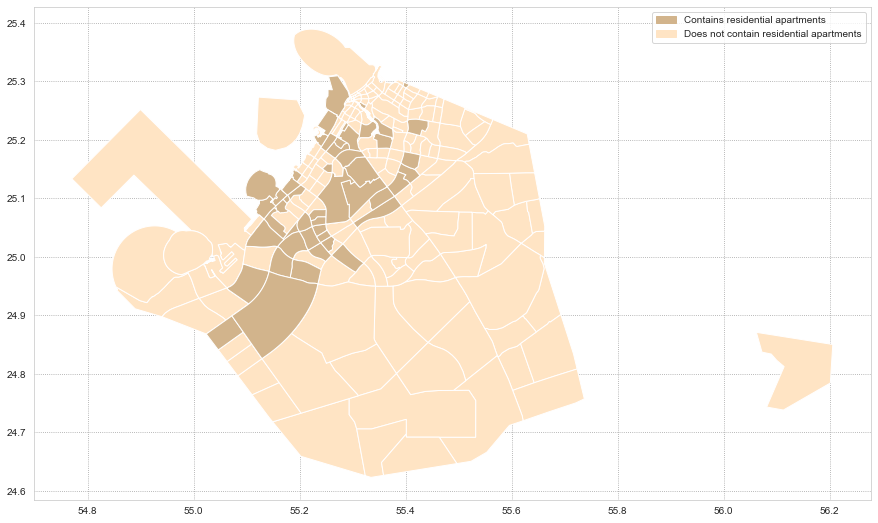

In [27]:
fig, ax = plt.subplots(figsize=(15,10))
dubai_polygons.plot(ax=ax, categorical=True, color='bisque')
residential_properties.plot(ax=ax, categorical=True, color='tan')

has_hotels = mpatches.Patch(label='Contains residential apartments', color='tan')
does_not_have_hotels = mpatches.Patch(color='bisque', label='Does not contain residential apartments')

plt.legend(handles=[has_hotels, does_not_have_hotels])
plt.axis()

### **Section 5:** Point of interest proximity and concentration

In order to complement the core regression analysis of this workbook, which relies on determining the relationship between mall proxmity and house prices in Dubai, externalities related to the concentrations of geospatial attributes are also considered.

Consequently, the distance from, and concentration of these geospatial externalities with repsect to the location of Dubai's residential buildings can be determined via the utilisation of a method that determines the point of interest count up until a certain radius around a hotel (determinePOICount) and the use of a method that can calculate the distance of an external feature from a hotel (CalculateDistance).

In [28]:
def determinePOICount(attribute, tag, threshold):
    counts = [];

    for i, row in merged_df.iterrows():
        count = 0
        for j, location in attribute.iterrows():
            coords1 = (merged_df.at[i, 'geometry'].y, merged_df.at[i, 'geometry'].x)
            coords2 = (attribute.at[j, 'geometry'].y, attribute.at[j, 'geometry'].x)

            distance = geopy.distance.geodesic(coords1, coords2).m
            if(distance < threshold):
                count += 1

        counts.append(count)

    merged_df[tag] = counts

In [29]:
def CalculateDistance(attribute, tag):
    distances = [];

    for i, row in merged_df.iterrows():
        closest_distance= 1000000000000000

        for j, location in attribute.iterrows():
            coords1 = (merged_df.at[i, 'geometry'].y, merged_df.at[i, 'geometry'].x)
            coords2 = (attribute.at[j, 'geometry'].y, attribute.at[j, 'geometry'].x)

            distance = geopy.distance.geodesic(coords1, coords2).m
            if(distance < closest_distance):
                closest_distance = distance

        distances.append(closest_distance)

    merged_df[tag] = distances

The distance of each hotel from the three CBDs extracted earlier is calcualted and then appended to the 'dubal_hotels' dataframe.

In [30]:
CalculateDistance(cbd_centroids[cbd_centroids.index=='DIFC, Downtown and Business Bay'],'closest distance to CBD (DIFC, Downtown and Business Bay)')
CalculateDistance(cbd_centroids[cbd_centroids.index=='Media city, Internet city, and Knowledge park'],'closest distance to CBD (Media city, Internet city, and Knowledge park)')
CalculateDistance(cbd_centroids[cbd_centroids.index=='Deira and Bur Dubai'],'closest distance to CBD (Deira and Bur Dubai)')

Additionally, distances are also determined from each hotel to a specific large sized mall.

In [31]:
largeMalls = dubai_malls[dubai_malls['LargeMall'] == True]
print(largeMalls.columns)
largeMalls[['name', 'LargeMall', 'MediumMall', 'SmallMall']]

Index(['name', 'geometry', 'area', 'LargeMall', 'MediumMall', 'SmallMall'], dtype='object')


,name,LargeMall,MediumMall,SmallMall
0,Deira City Centre,True,False,False
1,Dubai Mall,True,False,False
3,Dragon Mart,True,False,False
11,Ibn Battuta Mall,True,False,False
13,Mirdif City Center,True,False,False
19,Mall of the Emirates,True,False,False
40,Al Ghurair Center,True,False,False
49,Dragon Mart 2,True,False,False
50,Wafi Mall,True,False,False
81,The Outlet Village,True,False,False


In [32]:
for i, mall in largeMalls.iterrows():
    name = largeMalls.at[i, 'name']
    tag = 'closest distance to ' +  name
    subset  = largeMalls[largeMalls['name'] == name]
    CalculateDistance(subset, tag)

The distance a hotel is from it's closest medium and small sized mall is also determined.

In [33]:
MediumDistances = []
SmallDistances = []

mediumMall = False
smallMall = False

for i, row in merged_df.iterrows():

    closest_large_mall_distance = 1000000000000000
    closest_medium_mall_distance = 1000000000000000
    closest_small_mall_distance = 1000000000000000

    for j, mall in dubai_malls.iterrows():
        coords1 = (merged_df.at[i, 'geometry'].y, merged_df.at[i, 'geometry'].x)
        coords2 = (dubai_malls.at[j, 'geometry'].y, dubai_malls.at[j, 'geometry'].x)
        distance = geopy.distance.geodesic(coords1, coords2).m    

        if(dubai_malls.at[j, 'MediumMall']):
            mediumMall = True

        else:
            smallMall = True

        if(mediumMall  & (distance < closest_medium_mall_distance)):
            closest_medium_mall_distance = distance

        if(smallMall  & (distance < closest_small_mall_distance)):
            closest_small_mall_distance = distance

        mediumMall = False
        smallMall = False

    MediumDistances.append(closest_medium_mall_distance)
    SmallDistances.append(closest_small_mall_distance)

merged_df['closest medium mall distance'] = MediumDistances
merged_df['closest small mall distance'] = SmallDistances

merged_df

,No of Units,Building Name,Size [sqf],AED/sqf,geometry,"closest distance to CBD (DIFC, Downtown and Business Bay)","closest distance to CBD (Media city, Internet city, and Knowledge park)",closest distance to CBD (Deira and Bur Dubai),closest distance to Deira City Centre,closest distance to Dubai Mall,closest distance to Dragon Mart,closest distance to Ibn Battuta Mall,closest distance to Mirdif City Center,closest distance to Mall of the Emirates,closest distance to Al Ghurair Center,closest distance to Dragon Mart 2,closest distance to Wafi Mall,closest distance to The Outlet Village,closest medium mall distance,closest small mall distance
2,315.0,17 Icon Bay,841.000000,5061.111111,POINT (55.34530 25.20556),7131.371665,21975.670860,5370.212751,5314.276576,6724.206548,8070.463415,28859.552732,6385.701294,17501.075168,7495.987953,8702.053561,3665.905468,46868.307978,8350.181239,3665.905468
3,152.0,2020 Marquis,309.063158,7201.800000,POINT (55.23479 25.06535),15003.736466,8315.059729,21735.768406,22910.383292,15273.600224,21977.984602,11795.492076,24143.993431,6828.249202,23979.682850,22469.653894,20023.220797,28287.146529,4695.271148,6363.201221
5,288.0,23 Marina Tower,2906.432870,1395.113426,POINT (55.15092 25.08977),17178.194427,1482.334643,24143.039142,25656.591340,17575.582034,28429.671767,5870.664426,29426.124965,5923.189680,25944.378142,29011.194501,22937.134420,24240.152378,5513.236952,1779.773247
6,54.0,29 Burj Boulevard Podium,882.757576,2816.818182,POINT (55.27208 25.19211),515.027685,15185.787737,7560.211667,9009.513513,912.049210,14781.389538,22386.678752,13913.980296,10893.692017,9602.152650,15438.883163,6274.281300,40714.087346,2036.245565,543.689576
7,321.0,29 Burj Boulevard Tower 1,942.378218,2722.045545,POINT (55.27220 25.19202),514.529033,15188.360976,7560.405025,9008.240030,908.390082,14768.352114,22388.172996,13904.072989,10894.743981,9604.540056,15425.839256,6271.180952,40714.849756,2049.948831,538.854971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3791,86.0,Zazen One,135.913043,10241.695652,POINT (55.19474 25.05942),17142.537398,5557.683532,24136.544442,25461.725598,17475.208182,25773.434427,7704.870117,27610.586268,6566.486322,26240.966091,26291.394383,22591.884063,24731.456935,2128.101313,4664.849206
3793,157.0,Zen Cluster 02,50.600000,6464.600000,POINT (55.12960 25.04944),21873.708255,6376.840997,28894.048111,30368.482496,22258.242270,32119.605681,1088.162713,33572.363204,10467.349191,30767.443457,32664.172356,27594.665063,19378.664339,6897.631405,1088.162713
3829,194.0,Zenith Tower A1,986.053030,907.477273,POINT (55.21513 25.04405),17859.313618,8181.787968,24691.075240,25904.684588,18150.761730,24945.399645,9591.040197,27211.346864,8375.564149,26901.191659,25420.811440,23016.416400,25294.612009,1853.151011,6949.724157
3830,165.0,Zenith Tower A2,678.156250,1507.156250,POINT (55.22151 25.03524),18582.218398,9341.186157,25330.395630,26499.221077,18857.950367,25009.294570,10290.125505,27461.253591,9461.737592,27573.267211,25463.137015,23612.860200,25284.647716,2515.833146,7518.203530


Finally concentrations of transport links and traffic features within a 500 meter radius of each hotel in Dubai is determined.

This involves first specifying what these features are and then calculating distances for each hotel entry in the dataframe.

As can be observed below there are 6 categories of transport links and 17 categories of traffic features that are considered for this analysis.

In [34]:
dubai_transport_links = gpd.read_file("Data/Dubai Data/Transport/DubaiBusStops.shp")
dubai_transport_links = dubai_transport_links[['fclass', 'geometry']]
list(dubai_transport_links['fclass'].unique())

['bus_stop',
 'ferry_terminal',
 'railway_station',
 'taxi',
 'bus_station',
 'tram_stop']

In [35]:
dubai_bus_stop = dubai_transport_links[dubai_transport_links['fclass']=='bus_stop']
dubai_ferry_terminal = dubai_transport_links[dubai_transport_links['fclass']=='ferry_terminal']
dubai_railway_station = dubai_transport_links[dubai_transport_links['fclass']=='railway_station']
dubai_taxi = dubai_transport_links[dubai_transport_links['fclass']=='taxi']
dubai_bus_station = dubai_transport_links[dubai_transport_links['fclass']=='bus_station']
dubai_tram_stop = dubai_transport_links[dubai_transport_links['fclass']=='tram_stop']

In [36]:
dubai_traffic = gpd.read_file('Data/Dubai Data/Transport/DubaiTraffic.shp')
dubai_traffic = dubai_traffic[['fclass', 'geometry']]
list(dubai_traffic['fclass'].unique())

['traffic_signals',
 'motorway_junction',
 'crossing',
 'turning_circle',
 'mini_roundabout',
 'parking',
 'fuel',
 'marina',
 'parking_underground',
 'parking_multistorey',
 'stop',
 'slipway',
 'street_lamp',
 'speed_camera',
 'parking_bicycle',
 'lock_gate',
 'waterfall']

The following code determines the concentrations of transport links and traffic features within 500 meters of each hotel in Dubai.

In [37]:
determinePOICount(dubai_transport_links, 'Transport links within 500 meters', 500)

In [38]:
determinePOICount(dubai_traffic, 'Traffic features within 500 meters',500)

### **Section 6:** Visualising mall sizes

Dubais malls have been divided into small, medium and large sizes and the distribution of mall sizes within each of these categories is visualised below as is the relative proportion of the total mall count each category of mall size constitutes.

The following function generates a graph that represesents a frequency distribution histogram of malls of idfferent sizes.

In [39]:
def generateGraph(variable, variable_tag):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.hist(variable, color='bisque')
    ax.set_xlabel(variable_tag)
    ax.set_ylabel('Count')
    ax.set_title(variable_tag+" vs "+ 'Count')
    plt.show()

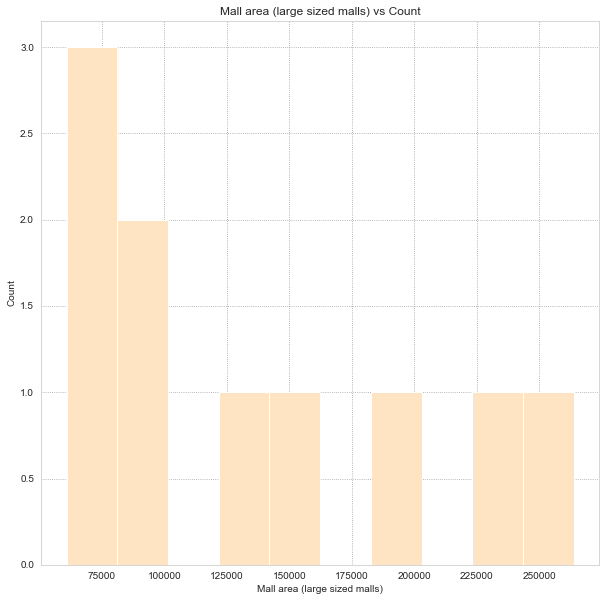

In [40]:
generateGraph(largeMalls['area'], 'Mall area (large sized malls)')

In [41]:
mediumMalls = dubai_malls[dubai_malls['MediumMall'] == True]
mediumMalls

,name,geometry,area,LargeMall,MediumMall,SmallMall
2,Al Barsha Mall,POINT (55.20464 25.09891),28900.155003,False,True,False
6,Oasis Centre,POINT (55.24168 25.16950),22198.716178,False,True,False
16,Dubai Outlet Mall,POINT (55.40052 25.07253),45000.497496,False,True,False
17,Sahara Centre,POINT (55.37329 25.29782),48930.891941,False,True,False
34,Madina Mall,POINT (55.39812 25.28205),25181.476483,False,True,False
47,Ma'aisem city center,POINT (55.19722 25.04034),28786.801111,False,True,False
51,Safeer Mall,POINT (55.37948 25.30905),21672.107503,False,True,False
52,سيتي سنتر الشارقه,POINT (55.39359 25.32471),37887.378693,False,True,False
64,City Walk,POINT (55.25920 25.21017),38290.503977,False,True,False
67,City Walk,POINT (55.26250 25.20829),21632.616971,False,True,False


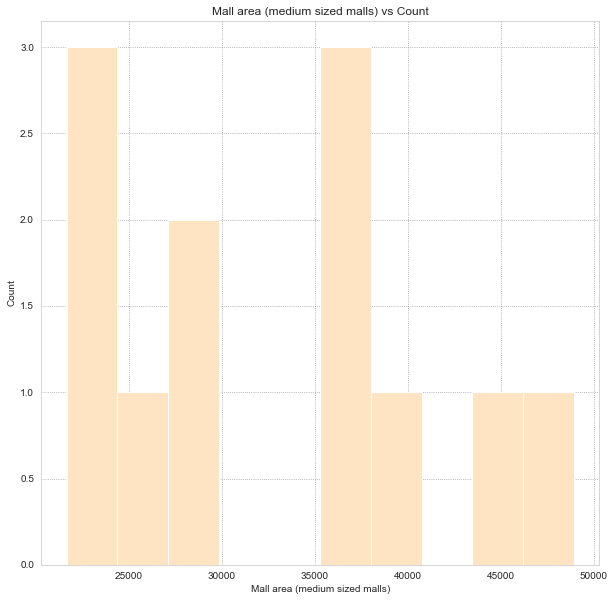

In [42]:
generateGraph(mediumMalls['area'], 'Mall area (medium sized malls)')

In [43]:
smallMalls = dubai_malls[dubai_malls['SmallMall'] == True]
smallMalls

,name,geometry,area,LargeMall,MediumMall,SmallMall
4,لولو هايبرماركت,POINT (55.20770 25.11722),14206.781049,False,False,True
5,Mazaya Shopping Centre,POINT (55.26540 25.19910),11081.823403,False,False,True
7,Times Square Centre,POINT (55.22004 25.13954),18461.629504,False,False,True
8,Grand City Mall,POINT (55.23241 25.12863),3453.992478,False,False,True
9,Atlantis Mall,POINT (55.11817 25.13170),17620.959676,False,False,True
...,...,...,...,...,...,...
76,Al Arab Mall,POINT (55.36899 25.30895),10000.371444,False,False,True
77,None,POINT (55.24569 25.19442),15900.760427,False,False,True
78,Grand Hyper,POINT (55.43077 25.26257),2807.062530,False,False,True
80,Al Qusan Plaza Shopping Center,POINT (55.38784 25.28127),1587.731735,False,False,True


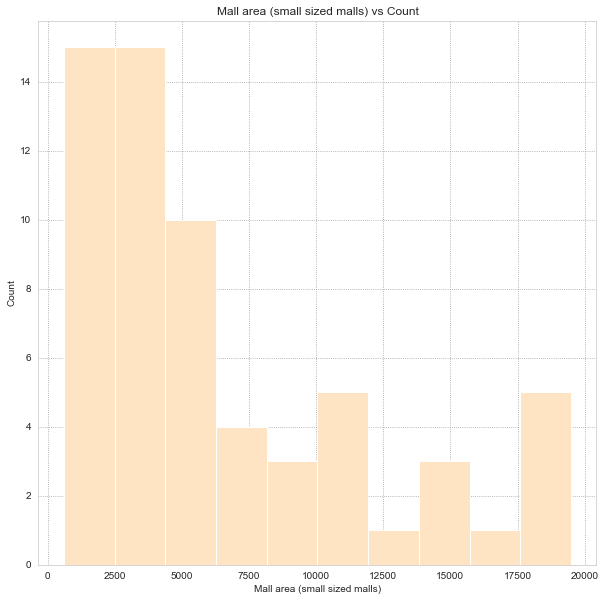

In [44]:
generateGraph(smallMalls['area'], 'Mall area (small sized malls)')

The following figure shows the percentage of malls of different sizes in Dubai.

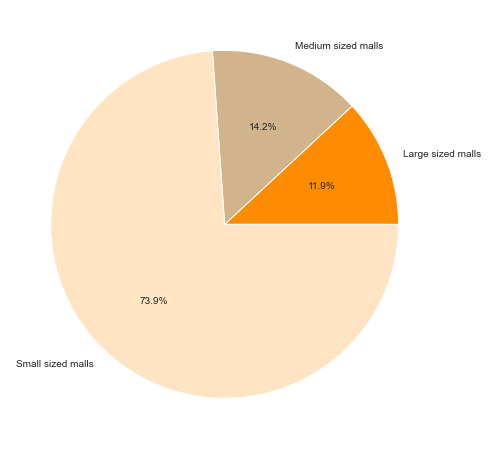

In [45]:
fig, ax = plt.subplots(figsize=(8, 8))
patches, texts, autotexts = ax.pie([11.9, 14.2, 73.8], autopct='%1.1f%%', labels=['Large sized malls', 'Medium sized malls', 'Small sized malls'], colors=['darkorange', 'tan', 'bisque'])


plt.show()

### **Section 7:** Regression

The final step of the analysis presented in this workbook involves determining the dependent and independent variables that will be utilised in the regression analysis a process that will involve the consideration of Variance Inflation Factors and the nature of the distribution of each independent variable, in order to determine the exsitance or lack thereof a linear relationship.

If a Variance Inflation Factor score is determined to be excessive a variable is removed, likewise the existance of a non-normal frequency distribution will involve the utilisation of a log transformation for an independent variable.

First the columns that exist within the dataframe that is created above can be highlighted as follows.

In [46]:
merged_df.columns

Index(['No of Units', 'Building Name', 'Size [sqf]', 'AED/sqf', 'geometry',
       'closest distance to CBD (DIFC, Downtown and Business Bay)',
       'closest distance to CBD (Media city, Internet city, and Knowledge park)',
       'closest distance to CBD (Deira and Bur Dubai)',
       'closest distance to Deira City Centre',
       'closest distance to Dubai Mall', 'closest distance to Dragon Mart',
       'closest distance to Ibn Battuta Mall',
       'closest distance to Mirdif City Center',
       'closest distance to Mall of the Emirates',
       'closest distance to Al Ghurair Center',
       'closest distance to Dragon Mart 2', 'closest distance to Wafi Mall',
       'closest distance to The Outlet Village',
       'closest medium mall distance', 'closest small mall distance',
       'Transport links within 500 meters',
       'Traffic features within 500 meters'],
      dtype='object')

Redundant and unnecssary columns can then be dropped.

In [47]:
merged_df.reset_index(inplace=True)
merged_df.set_index('Building Name', inplace=True)
merged_df.drop('geometry', axis=1, inplace=True)
print(merged_df.columns)
print(len(merged_df))

Index(['index', 'No of Units', 'Size [sqf]', 'AED/sqf',
       'closest distance to CBD (DIFC, Downtown and Business Bay)',
       'closest distance to CBD (Media city, Internet city, and Knowledge park)',
       'closest distance to CBD (Deira and Bur Dubai)',
       'closest distance to Deira City Centre',
       'closest distance to Dubai Mall', 'closest distance to Dragon Mart',
       'closest distance to Ibn Battuta Mall',
       'closest distance to Mirdif City Center',
       'closest distance to Mall of the Emirates',
       'closest distance to Al Ghurair Center',
       'closest distance to Dragon Mart 2', 'closest distance to Wafi Mall',
       'closest distance to The Outlet Village',
       'closest medium mall distance', 'closest small mall distance',
       'Transport links within 500 meters',
       'Traffic features within 500 meters'],
      dtype='object')
1725


Following this, dependent and independent variables can be extracted.

In [48]:
indpendent_variables = merged_df.drop('AED/sqf', axis=1)

In [49]:
dependent_variable = merged_df['AED/sqf'];

A logarithmic version of each independent variable is added to the 'merged_df' dataframe below.

In [50]:
for tag in indpendent_variables.columns:
    if(tag != 'index'):
        variable = merged_df[tag]
        log_variable = np.log(variable)
        newName = 'log '+ tag
        merged_df[newName] = log_variable
print(merged_df.columns)
print(len(merged_df))

Index(['index', 'No of Units', 'Size [sqf]', 'AED/sqf',
       'closest distance to CBD (DIFC, Downtown and Business Bay)',
       'closest distance to CBD (Media city, Internet city, and Knowledge park)',
       'closest distance to CBD (Deira and Bur Dubai)',
       'closest distance to Deira City Centre',
       'closest distance to Dubai Mall', 'closest distance to Dragon Mart',
       'closest distance to Ibn Battuta Mall',
       'closest distance to Mirdif City Center',
       'closest distance to Mall of the Emirates',
       'closest distance to Al Ghurair Center',
       'closest distance to Dragon Mart 2', 'closest distance to Wafi Mall',
       'closest distance to The Outlet Village',
       'closest medium mall distance', 'closest small mall distance',
       'Transport links within 500 meters',
       'Traffic features within 500 meters', 'log No of Units',
       'log Size [sqf]',
       'log closest distance to CBD (DIFC, Downtown and Business Bay)',
       'log closes

c:\Users\ankur\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ankur\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


A visual representation of the frequency distribution of values for each variable is highlighted below using the generate graph function.

In [51]:
def generateGraph(variable, variable_tag, counts):
    try:
        ax = plt.gca()
        ax.hist(variable)
        ax.set_xlabel(variable_tag)
        ax.set_ylabel('Count')
        ax.set_title(variable_tag+" vs "+ 'Count')
        plt.show()
    except:
        print()

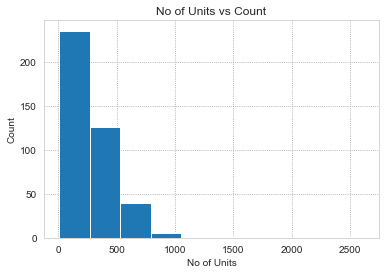

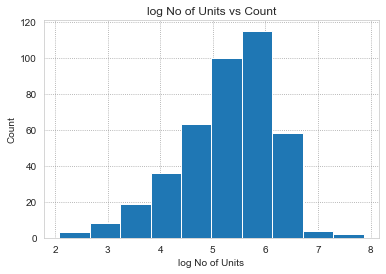

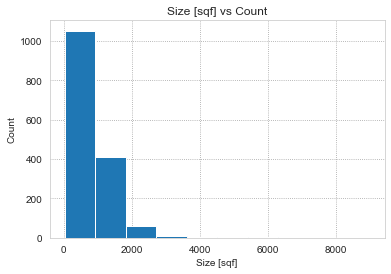

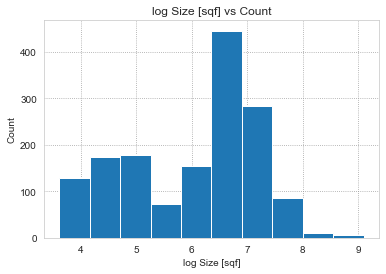

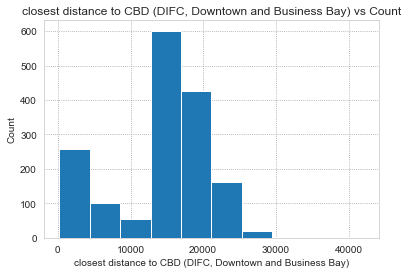

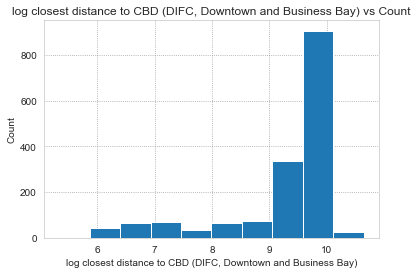

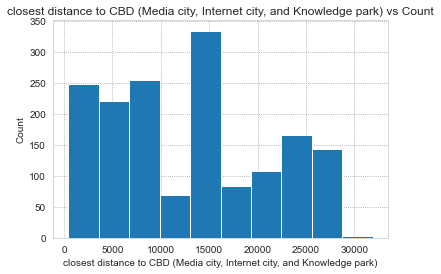

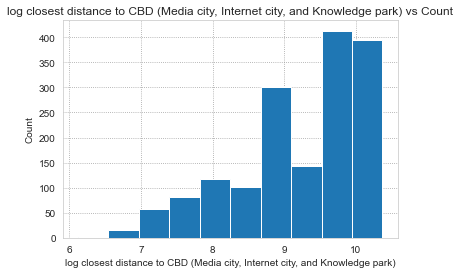

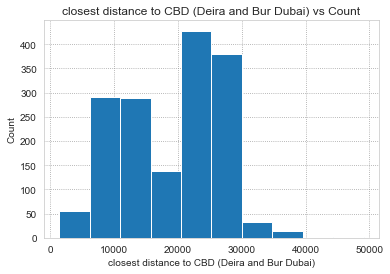

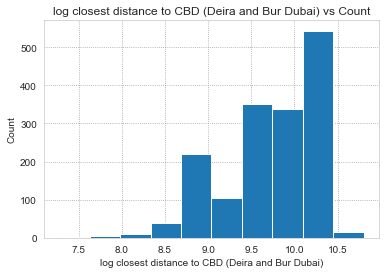

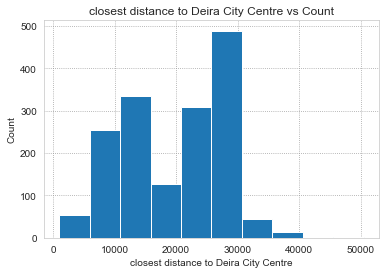

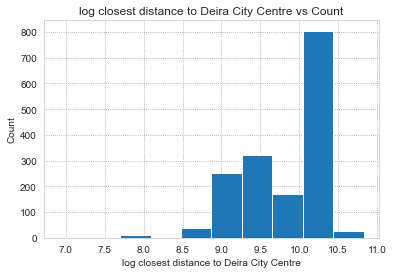

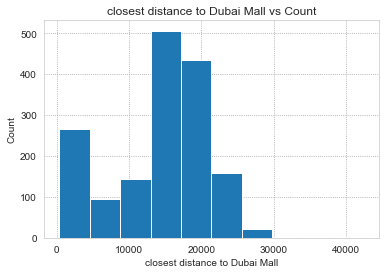

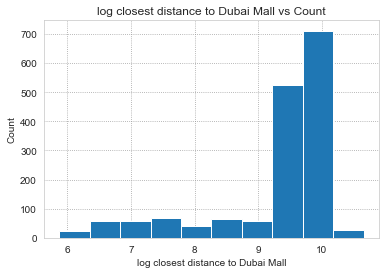

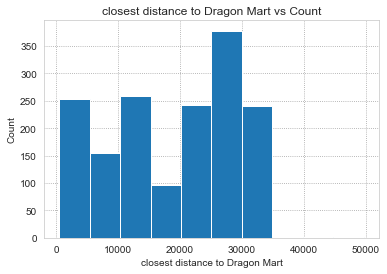

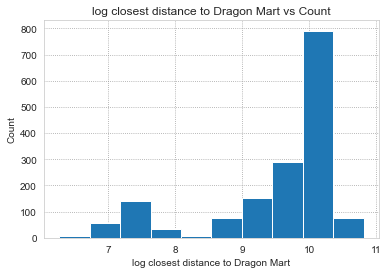

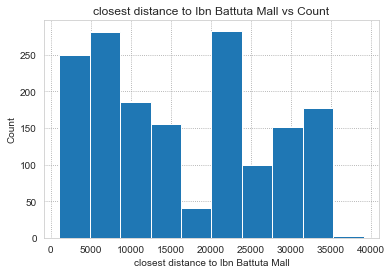

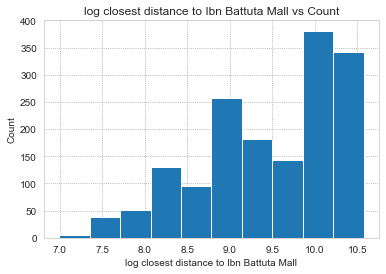

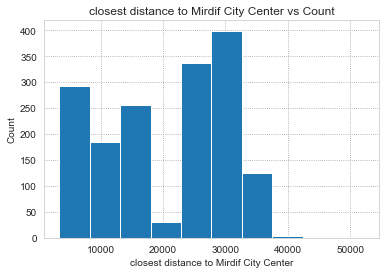

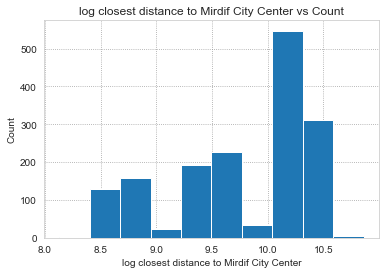

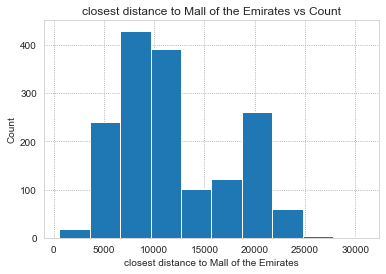

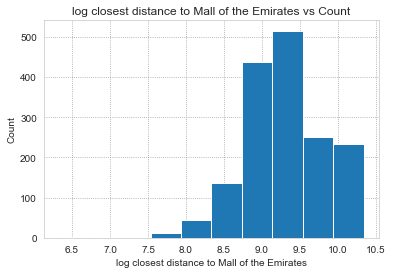

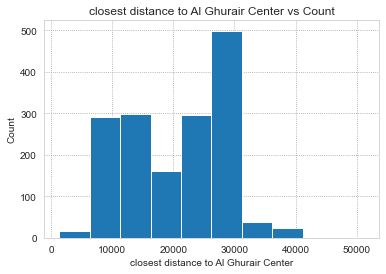

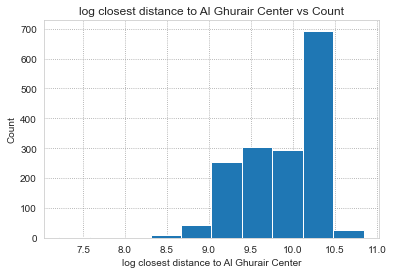

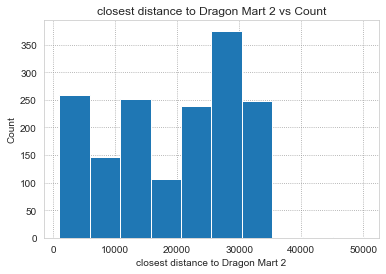

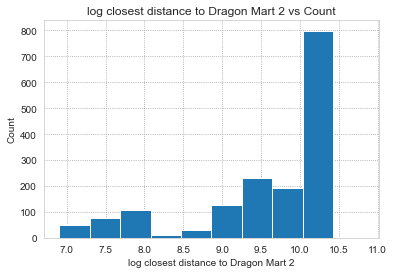

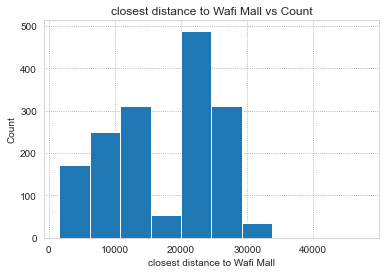

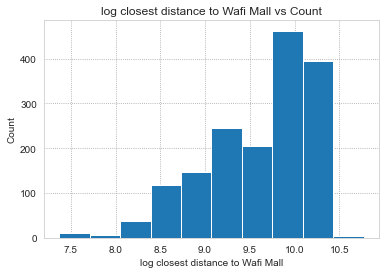

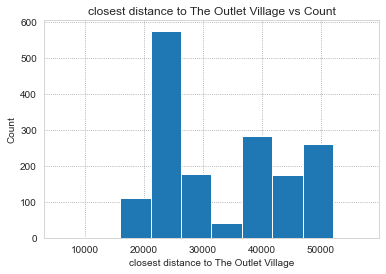

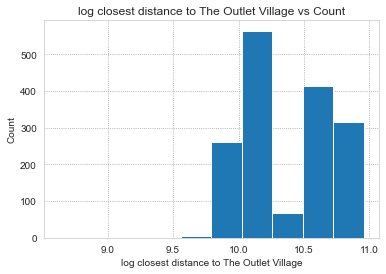

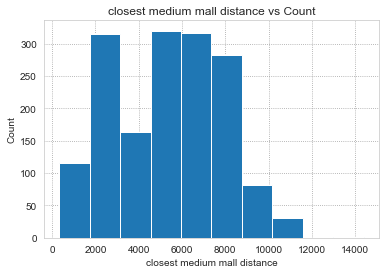

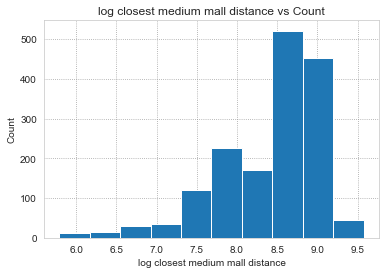

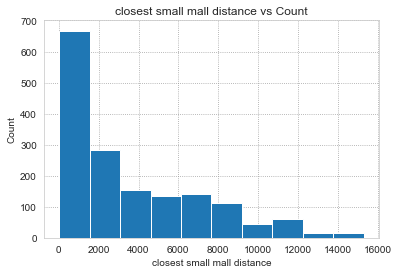

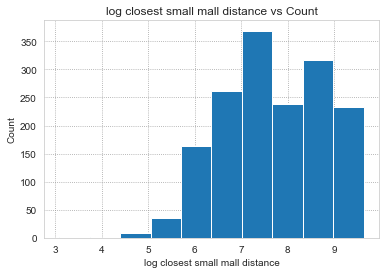

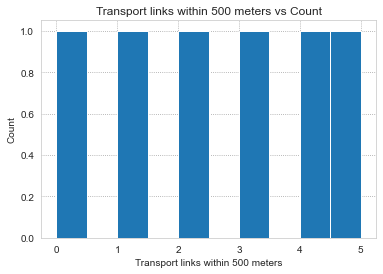

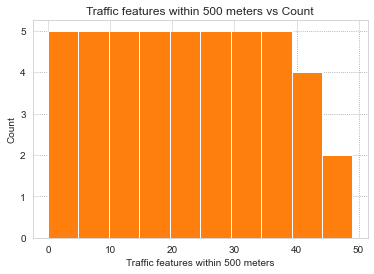

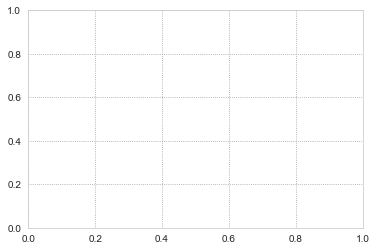

In [52]:
for tag in indpendent_variables.columns:
    if(tag!='index'):
        variable = merged_df[tag]
        value_by_count = variable.value_counts().to_dict()
        generateGraph(list(value_by_count.keys()), tag, list(value_by_count.values()))

        log_tag = 'log '+ tag
        log_variable = merged_df[log_tag]
        value_by_count = log_variable.value_counts().to_dict()
        generateGraph(list(value_by_count.keys()), log_tag, list(value_by_count.values()))

As can be observed only certain variables require a log-transformation in order to be normally distributed, columns for log-transformed variables that are not in requirement of such a transformation can be dropped from the dataframe prior to further regression analysis.

In [53]:
list(merged_df.columns)

['index',
 'No of Units',
 'Size [sqf]',
 'AED/sqf',
 'closest distance to CBD (DIFC, Downtown and Business Bay)',
 'closest distance to CBD (Media city, Internet city, and Knowledge park)',
 'closest distance to CBD (Deira and Bur Dubai)',
 'closest distance to Deira City Centre',
 'closest distance to Dubai Mall',
 'closest distance to Dragon Mart',
 'closest distance to Ibn Battuta Mall',
 'closest distance to Mirdif City Center',
 'closest distance to Mall of the Emirates',
 'closest distance to Al Ghurair Center',
 'closest distance to Dragon Mart 2',
 'closest distance to Wafi Mall',
 'closest distance to The Outlet Village',
 'closest medium mall distance',
 'closest small mall distance',
 'Transport links within 500 meters',
 'Traffic features within 500 meters',
 'log No of Units',
 'log Size [sqf]',
 'log closest distance to CBD (DIFC, Downtown and Business Bay)',
 'log closest distance to CBD (Media city, Internet city, and Knowledge park)',
 'log closest distance to CBD (De

Only the following independent variables need be considered.

In [54]:
final_independent_variables = merged_df[['closest distance to Deira City Centre','closest distance to Dubai Mall', 
'closest distance to Dragon Mart', 'closest distance to Ibn Battuta Mall',
       'closest distance to Mirdif City Center','closest distance to Al Ghurair Center',
       'closest distance to Dragon Mart 2', 'closest distance to Wafi Mall',
       'closest distance to The Outlet Village','closest distance to CBD (DIFC, Downtown and Business Bay)',
       'closest distance to CBD (Deira and Bur Dubai)','closest medium mall distance', 'closest small mall distance',
       'Transport links within 500 meters','Traffic features within 500 meters', 
       'log No of Units', 'log Size [sqf]',  'log closest distance to Mall of the Emirates', 'log closest distance to CBD (Media city, Internet city, and Knowledge park)']]

Columns can now be iteratively dropped based on their Variance Inflation Factor scores in order to prevent further regression analysis from being affected by multicolliearity.

The following function is from Quantitative Methods tutorial 4 (CASA0007) 
It calculates the VIF score of each independent variable and returns a dataframe containing independent variables that have a VIF score that is below 10

Source: https://moodle.ucl.ac.uk/pluginfile.php/3532739/mod_resource/content/6/Practical_advanced_regression_UPDATED.ipynb

In [55]:
def drop_column_using_vif_(df, thresh=10):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF.
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i)
                            for i in range(df_with_const.shape[1])],
                           name="VIF",
                           index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')

        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed.
        # This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns=index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

The utilisation of the above function removes the following variables from subsequent consideration in regression analysis.

In [56]:
final_independent_variables_vif = drop_column_using_vif_(final_independent_variables)
print(final_independent_variables_vif.columns)

Dropping: closest distance to CBD (Deira and Bur Dubai)
Dropping: closest distance to Deira City Centre
Dropping: closest distance to Dragon Mart
Dropping: closest distance to Dubai Mall
Dropping: closest distance to Mirdif City Center
Dropping: closest distance to Al Ghurair Center
Dropping: closest distance to The Outlet Village
Dropping: closest distance to Wafi Mall
Dropping: closest distance to Ibn Battuta Mall
Index(['closest distance to Dragon Mart 2',
       'closest distance to CBD (DIFC, Downtown and Business Bay)',
       'closest medium mall distance', 'closest small mall distance',
       'Transport links within 500 meters',
       'Traffic features within 500 meters', 'log No of Units',
       'log Size [sqf]', 'log closest distance to Mall of the Emirates',
       'log closest distance to CBD (Media city, Internet city, and Knowledge park)'],
      dtype='object')


In [57]:
stats = sm.OLS(endog=dependent_variable, exog=final_independent_variables_vif).fit()
stats.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                AED/sqf   R-squared (uncentered):                   0.734
Model:                            OLS   Adj. R-squared (uncentered):              0.732
Method:                 Least Squares   F-statistic:                              473.0
Date:                Sun, 21 Aug 2022   Prob (F-statistic):                        0.00
Time:                        10:45:57   Log-Likelihood:                         -16731.
No. Observations:                1725   AIC:                                  3.348e+04
Df Residuals:                    1715   BIC:                                  3.354e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================================================================
                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------
closest distance to Dragon Mart 2                                               0.3992      0.016     24.832      0.000       0.368       0.431
closest distance to CBD (DIFC, Downtown and Business Bay)                      -0.6510      0.028    -23.669      0.000      -0.705      -0.597
closest medium mall distance                                                    0.3050      0.049      6.224      0.000       0.209       0.401
closest small mall distance                                                     0.1066      0.043      2.486      0.013       0.023       0.191
Transport links within 500 meters                                            -522.0171    106.684     -4.893      0.000    -731.261    -312.773
Traffic features within 500 meters                                             -9.3142     10.697     -0.871      0.384     -30.294      11.666
log No of Units                                                              -310.8653    127.784     -2.433      0.015    -561.493     -60.237
log Size [sqf]                                                              -2932.4154     87.371    -33.563      0.000   -3103.780   -2761.051
log closest distance to Mall of the Emirates                                 5595.7660    398.914     14.027      0.000    4813.357    6378.175
log closest distance to CBD (Media city, Internet city, and Knowledge park) -3092.2882    348.733     -8.867      0.000   -3776.274   -2408.302
==============================================================================
Omnibus:                     1611.645   Durbin-Watson:                   1.307
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           106922.629
Skew:                           4.186   Prob(JB):                         0.00
Kurtosis:                      40.650   Cond. No.                     1.50e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.5e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""